# Playground Series S3E23 - Binary Classification with a Software Defects Dataset

https://www.kaggle.com/competitions/playground-series-s3e23

https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction

## Setup

In [118]:
import os
import glob
from pathlib import Path
import random
import time
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import xgboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, f1_score, precision_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [61]:
IS_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

COMP_NAME = 'playground-series-s3e23'
if COMP_NAME is None:
    raise NameError('COMP_NAME has not been initialized')

DATA_PATH = Path('../input/' + COMP_NAME) if IS_KAGGLE else Path('./data')

RANDOM_SEED = 42

In [62]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Load Data

In [63]:
path = Path('./data')
if not DATA_PATH.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(COMP_NAME)
    zipfile.ZipFile(f'{COMP_NAME}.zip').extractall(DATA_PATH)

In [64]:
train_data = pd.read_csv(DATA_PATH / 'train.csv')
test_data = pd.read_csv(DATA_PATH / 'test.csv')

print('train:', train_data.shape)
print('test:', test_data.shape)

train: (101763, 23)
test: (67842, 22)


## Data Exploration

In [65]:
train_data.head(5)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [66]:
test_data.head(5)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,101763,33.0,5.0,1.0,4.0,144.0,824.82,0.04,26.96,30.05,...,1257.60,30,0,3,0,21.0,23.0,87.0,57.0,9.0
1,101764,27.0,8.0,8.0,2.0,125.0,646.24,0.04,22.82,27.22,...,804.58,23,0,2,0,18.0,19.0,70.0,49.0,15.0
2,101765,130.0,11.0,7.0,10.0,545.0,3831.40,0.02,48.15,66.17,...,6453.34,99,9,17,1,26.0,53.0,333.0,244.0,21.0
3,101766,65.0,7.0,1.0,7.0,156.0,855.71,0.06,17.23,49.89,...,896.42,45,8,10,0,15.0,26.0,88.0,60.0,13.0
4,101767,22.0,3.0,1.0,3.0,52.0,238.42,0.10,9.60,26.70,...,145.80,16,0,4,0,12.0,15.0,30.0,24.0,5.0


### Attribute Information

Snippet from https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction

```txt
loc                McCabe's line count of code 
v(g)               McCabe "cyclomatic complexity" 
ev(g)              McCabe "essential complexity" 
iv(g)              McCabe "design complexity" 
n                  Halstead total operators + operands 
v                  Halstead "volume" 
l                  Halstead "program length" 
d                  Halstead "difficulty" 
i                  Halstead "intelligence" 
e                  Halstead "effort" 
b                  Halstead 
t                  Halstead's time estimator 
lOCode             Halstead's line count 
lOComment          Halstead's count of lines of comments 
lOBlank            Halstead's count of blank lines 
lOCodeAndComment   
uniq_Op            unique operators 
uniq_Opnd          unique operands 
total_Op           total operators 
total_Opnd         total operands 
branchCount        flow graph 
defects            module has/has not one or more reported defects 
```

In [165]:
train_data.dtypes

id                     int64
loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects                 bool
dtype: object

In [67]:
num_cols = train_data.select_dtypes(exclude='object')
print('Numerical columns:\n', num_cols.columns)

Numerical columns:
 Index(['id', 'loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e',
       'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount',
       'defects'],
      dtype='object')


In [68]:
cat_cols = train_data.select_dtypes(exclude=['int64', 'float64'])
print('Categorical columns:\n', cat_cols.columns)

Categorical columns:
 Index(['defects'], dtype='object')


In [69]:
missing_counts = train_data.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

Series([], dtype: int64)


In [70]:
print(train_data['defects'].value_counts())

defects
False    78699
True     23064
Name: count, dtype: int64


In [71]:
corr = train_data.corr()
print(corr[['defects']].sort_values(by=['defects']))

                    defects
l                 -0.253237
id                 0.001976
e                  0.095366
t                  0.099592
locCodeAndComment  0.133150
uniq_Op            0.178474
lOComment          0.205402
i                  0.208577
v                  0.231179
b                  0.232594
d                  0.241936
iv(g)              0.245618
uniq_Opnd          0.246113
total_Op           0.250533
lOCode             0.250604
total_Opnd         0.252752
lOBlank            0.257819
n                  0.258080
ev(g)              0.259928
v(g)               0.301187
branchCount        0.322827
loc                0.342642
defects            1.000000


## Prepare Training/Validation Data

In [276]:
X = train_data.dropna(axis=0, subset=['id', 'defects'])
y = train_data['defects']

In [277]:
features = [
    'loc', 
    'v(g)', 
    'ev(g)', 
    'iv(g)', 
    'n', 
    'v', 
    # 'l', 
    'd', 
    'i', 
    'e',
    'b', 
    't', 
    'lOCode', 
    'lOComment', 
    'lOBlank', 
    'locCodeAndComment',
    'uniq_Op', 
    'uniq_Opnd', 
    'total_Op', 
    'total_Opnd', 
    'branchCount',
]

X = X[features]

print(X.shape)

(101763, 20)


In [278]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED, stratify=y)

print('train:', 'X =', X_train.shape, ', y=', y_train.shape)
print('valid:', 'X =', X_valid.shape, ', y=', y_valid.shape)

train: X = (81410, 20) , y= (81410,)
valid: X = (20353, 20) , y= (20353,)


## XGB Classifier

In [280]:
model = xgboost.XGBClassifier(random_state=RANDOM_SEED, max_depth=5, n_estimators=200, learning_rate=0.025)
model.fit(X_train, y_train)
y_valid_preds = model.predict(X_valid)

print('Accuracy:', accuracy_score(y_valid_preds, y_valid))
print('Precision score:', precision_score(y_valid_preds, y_valid))
print('F1 score:', f1_score(y_valid_preds, y_valid))
print('Recall score:', recall_score(y_valid_preds, y_valid))
print('ROC AUC score:', roc_auc_score(y_valid_preds, y_valid))

Accuracy: 0.8145727902520513
Precision score: 0.3843485800997182
F1 score: 0.48442622950819675
Recall score: 0.6549685999261174
ROC AUC score: 0.7470128050066946


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

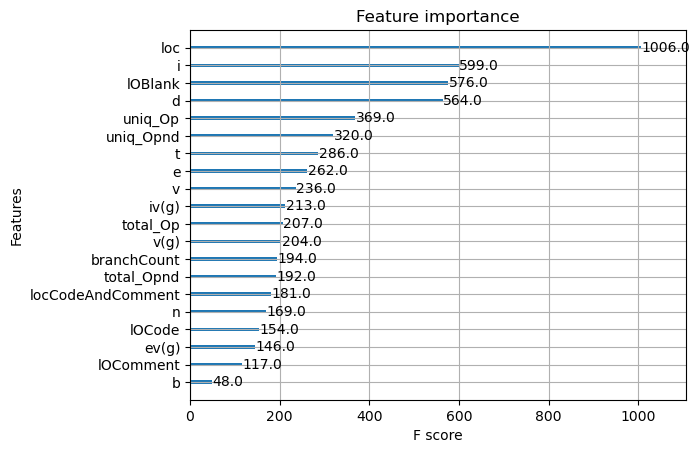

In [281]:
xgboost.plot_importance(model)

## Decision Tree Classifier

In [282]:
model = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=50)
model.fit(X_train, y_train)
y_valid_preds = model.predict(X_valid)

print('Accuracy:', accuracy_score(y_valid_preds, y_valid))
print('Precision score:', precision_score(y_valid_preds, y_valid))
print('F1 score:', f1_score(y_valid_preds, y_valid))
print('Recall score:', recall_score(y_valid_preds, y_valid))
print('ROC AUC score:', roc_auc_score(y_valid_preds, y_valid))

Accuracy: 0.7204834668107896
Precision score: 0.4140472577498374
F1 score: 0.4017246818803239
Recall score: 0.3901143790849673
ROC AUC score: 0.6076210764545623


## Random Forest Classifier

In [283]:
model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=2, max_depth=10, n_estimators=200)
model.fit(X_train, y_train)
y_valid_preds = model.predict(X_valid)

print('Accuracy:', accuracy_score(y_valid_preds, y_valid))
print('Precision score:', precision_score(y_valid_preds, y_valid))
print('F1 score:', f1_score(y_valid_preds, y_valid))
print('Recall score:', recall_score(y_valid_preds, y_valid))
print('ROC AUC score:', roc_auc_score(y_valid_preds, y_valid))

Accuracy: 0.8143271262221785
Precision score: 0.37784522003034904
F1 score: 0.4798348245010323
Recall score: 0.6572398190045249
ROC AUC score: 0.747551043336509


## Submission

In [284]:
model = xgboost.XGBClassifier(random_state=RANDOM_SEED, max_depth=5, n_estimators=200, learning_rate=0.025)
model.fit(X_train, y_train)
y_valid_preds = model.predict(X_valid)

X_test = test_data[features]
y_test_preds = model.predict(X_test)

In [285]:
probs = model.predict_proba(X_test)
print(probs)

[[0.7609341  0.2390659 ]
 [0.801487   0.19851299]
 [0.31588095 0.68411905]
 ...
 [0.83409137 0.16590863]
 [0.89728814 0.10271186]
 [0.22017789 0.7798221 ]]


In [286]:
submission = pd.DataFrame({'id': test_data['id'], 'defects': probs[:,1]})
submission.to_csv('submission.csv', index=False)